In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [88]:
## This method is for determening outliers
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper_ouliers = Q3 + 1.5 * IQR
    lower_outliers = Q1 - 1.5 * IQR
    outliers = series[(series < lower_outliers) | (series > upper_ouliers)]
    return len(outliers)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]  

## Content of the tables
### Chemicals table - all of the concentration of the specific chemical, code for the sensor, amount of water(all the data is from 2023)
### Merged_oxygen table - the code of the sensor(it is either 01/07, but it is the same sensor), amount of oxygen, start time, end time(data from 2021)


In [102]:
ammonium = pd.read_parquet('data/Chemical measurements influent 2023_2024/ammonium_2024.parquet')
ammonium = ammonium.rename(columns={"hstWaarde": "hstWaarde_ammonium_2023", "historianTagnummer": "historianTagnummer_ammonium", "datumBeginMeting": "datumBeginMeting_ammonium", "datumEindeMeting": "datumEindeMeting_ammonium"}).reset_index(drop=True)
ammonium['hstWaarde_ammonium_2023'] = ammonium['hstWaarde_ammonium_2023'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc726daeb10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc6fce324b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc6ff3d5f70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc6fce31220>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc6fcf47200>],
 'means': []}

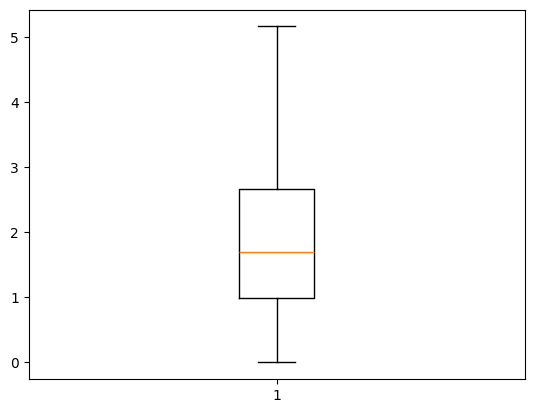

In [100]:
outliers_count = count_outliers_iqr(ammonium['hstWaarde_ammonium_2023'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(ammonium['hstWaarde_ammonium_2023'])

<Axes: >

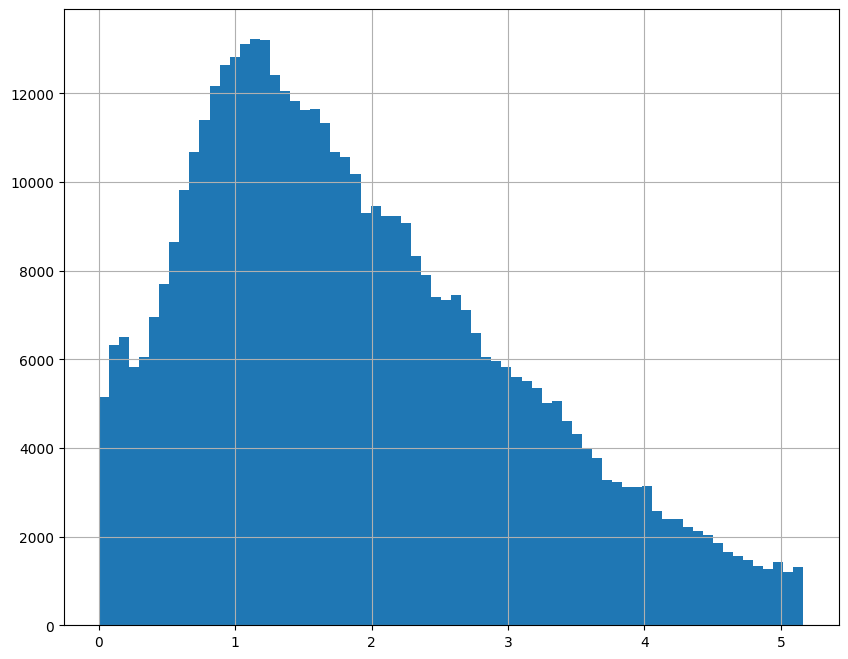

In [101]:
ammonium = remove_outliers_iqr(ammonium, 'hstWaarde_ammonium_2023')
ammonium['hstWaarde_ammonium_2023'].hist(bins=70, figsize=(10, 8))

In [92]:
nitrate = pd.read_parquet('data/Chemical measurements influent 2023_2024/nitrate_2024.parquet')
nitrate = nitrate.rename(columns={"hstWaarde": "hstWaarde_nitrate", "historianTagnummer": "historianTagnummer_nitrate"}).reset_index(drop=True)
nitrate['hstWaarde_nitrate'] = nitrate['hstWaarde_nitrate'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc6fd09cd10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc6fd09ff50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc6fd09fd10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc6fd09de50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc6fd09e3f0>],
 'means': []}

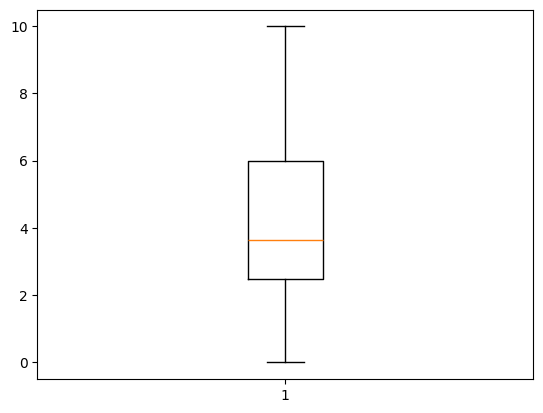

In [83]:
outliers_count = count_outliers_iqr(nitrate['hstWaarde_nitrate'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(nitrate['hstWaarde_nitrate'])

<Axes: >

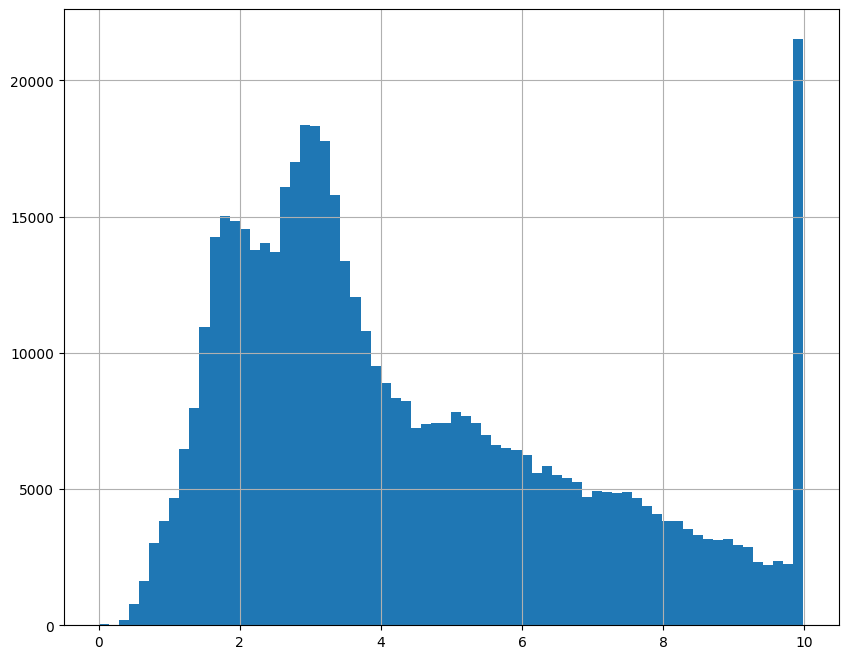

In [103]:
nitrate = remove_outliers_iqr(nitrate, 'hstWaarde_nitrate')
nitrate['hstWaarde_nitrate'].hist(bins=70, figsize=(10, 8))

In [115]:
phosphate = pd.read_parquet('data/Chemical measurements influent 2023_2024/phosphate_2024.parquet')
phosphate = phosphate.rename(columns={"hstWaarde": "hstWaarde_phosphate", "historianTagnummer": "historianTagnummer_phosphate"}).reset_index(drop=True)
phosphate['hstWaarde_phosphate'] = phosphate['hstWaarde_phosphate'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  21886


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc6f8b00320>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc6f8b030b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc725eded80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc6f8b03680>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc6f8b03950>],
 'means': []}

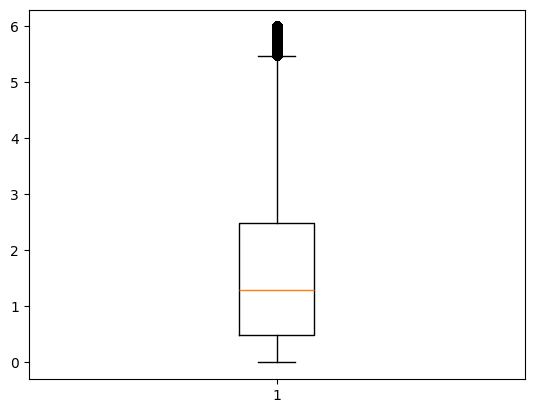

In [116]:
outliers_count = count_outliers_iqr(phosphate['hstWaarde_phosphate'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(phosphate['hstWaarde_phosphate'])

<Axes: >

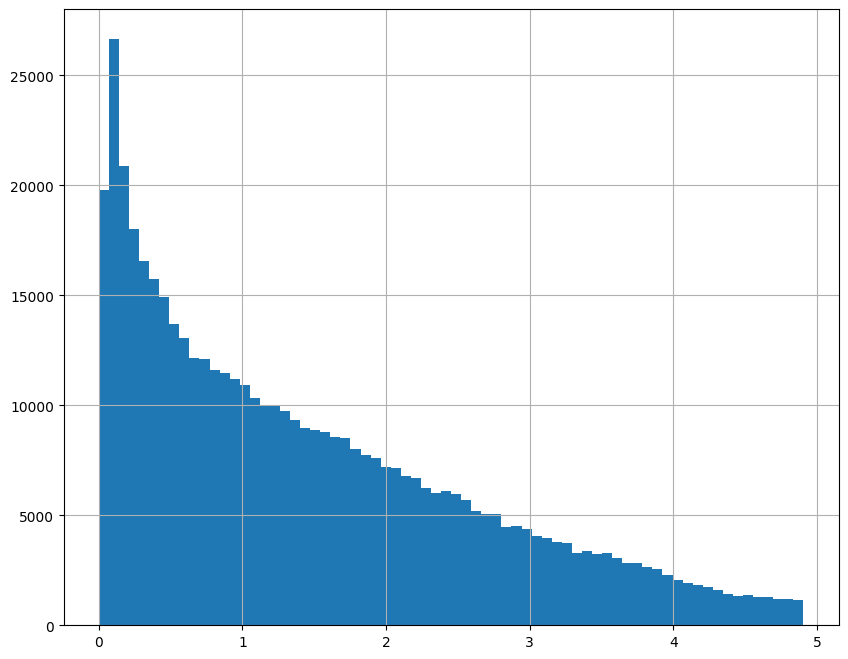

In [113]:
phosphate = remove_outliers_iqr(phosphate, 'hstWaarde_phosphate')
phosphate['hstWaarde_phosphate'].hist(bins=70, figsize=(10, 8))

In [117]:
ammonium_desc = ammonium.describe()
nitrate_desc = nitrate.describe()
phosphate_desc = phosphate.describe()

ammonium_desc.columns = [f'Ammonium_{col}' for col in ammonium_desc.columns]
nitrate_desc.columns = [f'Nitrate_{col}' for col in nitrate_desc.columns]
phosphate_desc.columns = [f'Phosphate_{col}' for col in phosphate_desc.columns]

summary_df = pd.concat([ammonium_desc, nitrate_desc, phosphate_desc], axis=1)
summary_df

,Ammonium_hstWaarde_ammonium_2023,Nitrate_hstWaarde_nitrate,Phosphate_hstWaarde_phosphate
count,525049.000000,525049.000000,525049.000000
mean,2.749274,4.384240,1.701335
std,2.913838,2.461896,1.515728
min,0.000000,0.000000,0.000000
25%,1.080000,2.482000,0.484000
50%,1.902000,3.635000,1.286000
75%,3.194000,6.004000,2.481000
max,19.985000,9.990000,5.994000


In [118]:
water_flow = pd.read_parquet('data/Influent_Flow_2023.parquet')
water_flow = water_flow.rename(columns={"hstWaarde": "hstWaarde_water"}).reset_index(drop=True)
water_flow['hstWaarde_water'] = water_flow['hstWaarde_water'].apply(pd.to_numeric, errors='coerce')

In [119]:
chemicals = pd.concat([ammonium, nitrate, phosphate, water_flow['hstWaarde_water']], axis=1)
chemicals = chemicals.drop(columns=['waardebewerkingsmethodeCode', 'datumBeginMeting', 'datumEindeMeting'])
chemicals.dropna()

,historianTagnummer_ammonium,hstWaarde_ammonium_2023,datumBeginMeting_ammonium,datumEindeMeting_ammonium,historianTagnummer_nitrate,hstWaarde_nitrate,historianTagnummer_phosphate,hstWaarde_phosphate,hstWaarde_water
0,EDE_B121069913_K600.MTW,1.310,2023-01-01 00:00:00,2023-01-01 00:01:00,EDE_B121069914_K600.MTW,4.730,EDE_B121069917_K600.MTW,0.001,3330.199
1,EDE_B121069913_K600.MTW,1.251,2023-01-01 00:01:00,2023-01-01 00:02:00,EDE_B121069914_K600.MTW,4.730,EDE_B121069917_K600.MTW,0.001,3288.798
2,EDE_B121069913_K600.MTW,1.182,2023-01-01 00:02:00,2023-01-01 00:03:00,EDE_B121069914_K600.MTW,4.730,EDE_B121069917_K600.MTW,0.000,3260.545
3,EDE_B121069913_K600.MTW,1.181,2023-01-01 00:03:00,2023-01-01 00:04:00,EDE_B121069914_K600.MTW,4.675,EDE_B121069917_K600.MTW,0.000,3253.279
4,EDE_B121069913_K600.MTW,1.179,2023-01-01 00:04:00,2023-01-01 00:05:00,EDE_B121069914_K600.MTW,4.605,EDE_B121069917_K600.MTW,0.000,3263.276
...,...,...,...,...,...,...,...,...,...
525044,EDE_B121069913_K600.MTW,1.688,2023-12-31 23:55:00,2023-12-31 23:56:00,EDE_B121069914_K600.MTW,8.916,EDE_B121069917_K600.MTW,0.160,2977.093
525045,EDE_B121069913_K600.MTW,1.665,2023-12-31 23:56:00,2023-12-31 23:57:00,EDE_B121069914_K600.MTW,9.059,EDE_B121069917_K600.MTW,0.139,2813.077
525046,EDE_B121069913_K600.MTW,1.642,2023-12-31 23:57:00,2023-12-31 23:58:00,EDE_B121069914_K600.MTW,9.073,EDE_B121069917_K600.MTW,0.097,2759.432
525047,EDE_B121069913_K600.MTW,1.619,2023-12-31 23:58:00,2023-12-31 23:59:00,EDE_B121069914_K600.MTW,9.088,EDE_B121069917_K600.MTW,0.096,2702.386


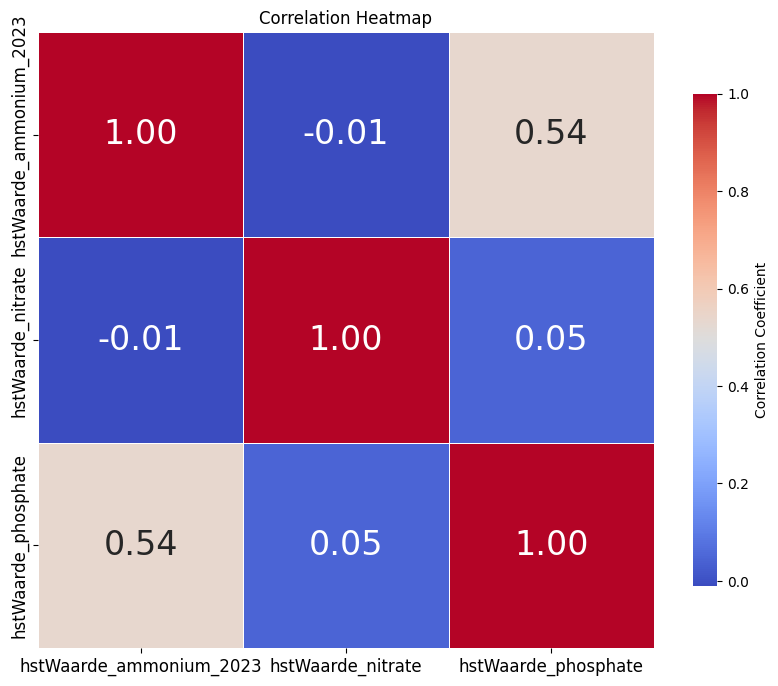

In [120]:
chemicalsForCorr = chemicals[['hstWaarde_ammonium_2023', 'hstWaarde_nitrate', 'hstWaarde_phosphate']]
corr = chemicalsForCorr.corr()
plt.figure(figsize=(10, 8))
plt.title("Correlation Heatmap")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(
    corr,
    annot=True,
    annot_kws={"size": 24},       # Font size for numbers
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}  # Optional
)
plt.show()

In [126]:
oxygen_a = pd.read_parquet('data/OxygenData2024/oxygen_a_2024.parquet')
oxygen_a = oxygen_a.drop(columns=['waardebewerkingsmethodeCode'])
legacy_oxygen_a = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Oxygen Data/zuurstofA_EDE_B121069901_K600.MTW.parquet')

oxygen_b = pd.read_parquet('data/OxygenData2024/oxygen_b_2024.parquet')
oxygen_b = oxygen_b.drop(columns=['waardebewerkingsmethodeCode'])
legacy_oxygen_b = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Oxygen Data/zuurstofB_EDE_B121069907_K600.MTW.parquet')

##Todo
## merge the tables, but there are two problems:
## 1. the tagnummer are different even though they are for the same thing
## 2. if we want to merge them there is size difference, which makes us run into an error(around 61 days of data is missing)

,historianTagnummer,hstWaarde,datumBeginMeting,datumEindeMeting
0,EDE_B121069901_K600.MTW,0.003,2021-01-01 00:00:00,2021-01-01 00:01:00
1,EDE_B121069901_K600.MTW,0.003,2021-01-01 00:01:00,2021-01-01 00:02:00
2,EDE_B121069901_K600.MTW,0.003,2021-01-01 00:02:00,2021-01-01 00:03:00
3,EDE_B121069901_K600.MTW,0.003,2021-01-01 00:03:00,2021-01-01 00:04:00
4,EDE_B121069901_K600.MTW,0.003,2021-01-01 00:04:00,2021-01-01 00:05:00
...,...,...,...,...
43195,EDE_B121069901_K600.MTW,0,2021-11-30 23:55:00,2021-11-30 23:56:00
43196,EDE_B121069901_K600.MTW,0,2021-11-30 23:56:00,2021-11-30 23:57:00
43197,EDE_B121069901_K600.MTW,0,2021-11-30 23:57:00,2021-11-30 23:58:00
43198,EDE_B121069901_K600.MTW,0,2021-11-30 23:58:00,2021-11-30 23:59:00


Text(0.5, 1.0, 'Distribution of ammonium in 2021')

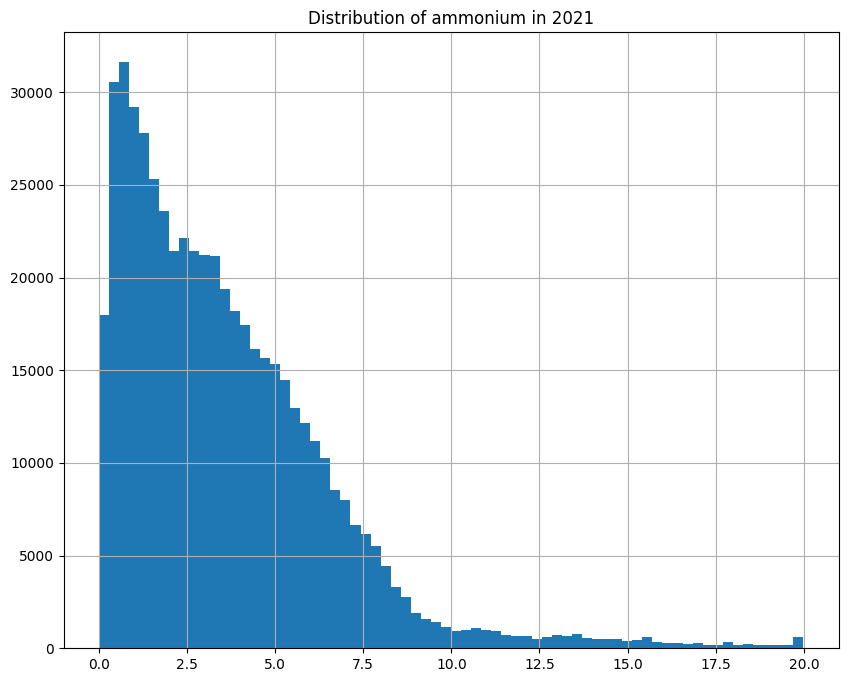

In [122]:
sensor_13 = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Data/EDE_B121069913_K600.MTW.parquet')
sensor_13['hstWaarde'] = sensor_13['hstWaarde'].apply(pd.to_numeric, errors='coerce')
sensor_13 = sensor_13.rename(columns={"hstWaarde": "hstWaarde_ammonium_2021"}).reset_index(drop=True)
sensor_13.hist(bins=70, figsize=(10, 8))
plt.title(f'Distribution of ammonium in 2021')

Text(0.5, 1.0, 'Distribution of ammonium in 2023')

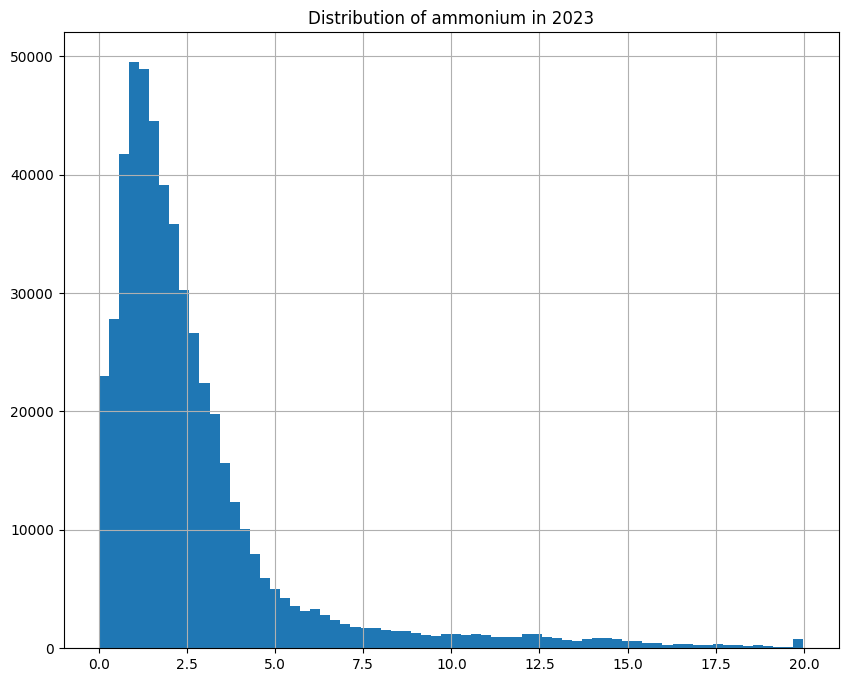

In [123]:
ammonium.hist(bins=70, figsize=(10, 8))
plt.title(f'Distribution of ammonium in 2023')

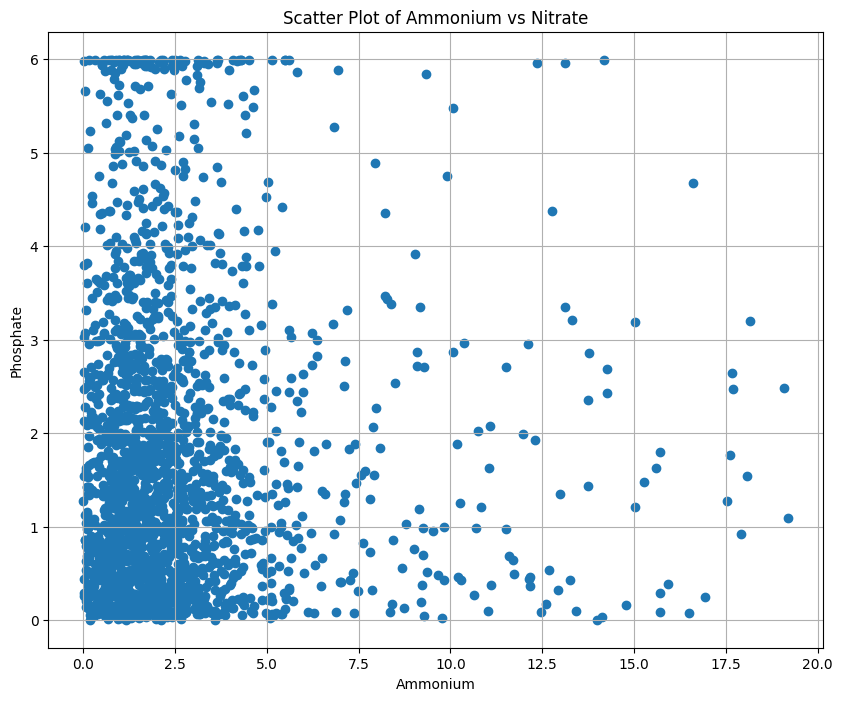

In [124]:
plt.figure(figsize=(10, 8))
plt.scatter(chemicals['hstWaarde_ammonium_2023'].sample(2000), chemicals['hstWaarde_phosphate'].sample(2000))
plt.xlabel('Ammonium')
plt.ylabel('Phosphate')
plt.title('Scatter Plot of Ammonium vs Nitrate')
plt.grid(True)